# TABLE OF CONTENTS:
---
* [Notebook Summary](#Notebook-Summary)
* [Setup](#Setup)
    * [Notebook Parameters](#Notebook-Parameters)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Retrieve the Registered Model](#Retrieve-the-Registered-Model)
* [Retrieve the Registered Inference Environment](#Retrieve-the-Registered-Inference-Environment)
* [Inference Artifacts & Configuration](#Inference-Artifacts-&-Configuration)
* [Model Deployment (Local)](#Model-Deployment-(Local))
    * [Initial Local Deployment](#Initial-Local-Deployment)
    * [Update Local Deployment](#Update-Local-Deployment)
    * [Local Webservice Testing](#Local-Webservice-Testing)
    * [Local Webservice Clean Up](#Local-Webservice-Clean-Up)
* [Model Deployment (Compute Target)](#Model-Deployment-(Compute-Target))
    * [Option 1: Deploy to ACI (Azure Container Instances)](#Option-1:-Deploy-to-ACI-(Azure-Container-Instances))
        * [ACI Webservice Testing](#ACI-Webservice-Testing)
        * [ACI Webservice Clean Up](#ACI-Webservice-Clean-Up)
    * [Option 2: Deploy to AKS (Azure Kubernetes Service)](#Option-2:-Deploy-to-AKS-(Azure-Kubernetes-Service))
        * [AKS Webservice Testing](#AKS-Webservice-Testing)
        * [AKS Webservice Clean Up](#AKS-Webservice-Clean-Up)
* [Model Deployment (Docker Image)](#Model-Deployment-(Docker-Image)) 
    * [Model Packaging](#Model-Packaging)
        * [Option 1: Download a Packaged Model](#Option-1:-Download-a-Packaged-Model)
        * [Option 2: Generate a Dockerfile](#Option-2:-Generate-a-Dockerfile)   
        * [Model Packaging Local Deployment](#Model-Packaging-Local-Deployment)
        * [Model Packaging Local Webservice Testing](#Model-Packaging-Local-Webservice-Testing)
        * [Model Packaging Clean Up](#Model-Packaging-Clean-Up)
    * [Deploy Docker Image to AKS](#Deploy-Docker-Image-to-AKS)
        * [Option 1: Deploy Image to AKS Using Python SDK](#Option-1:-Deploy-Image-to-AKS-Using-Python-SDK)
        * [Option 2: Deploy Image to AKS Using Kubectl](#Option-2:-Deploy-Image-to-AKS-Using-Kubectl)
    * [Test the Deployed Webservice](#Test-the-Deployed-Webservice)
* [Model Webservice Testing](#Model-Webservice-Testing)
    * [Python SDK](#Python-SDK)
    * [Send HTTP Request](#Send-HTTP-Request)
* [Resource Clean Up](#Resource-Clean-Up)
---

# Notebook Summary

In this notebook, the Azure Machine Learning (AML) model that has been trained in the `02_model_training` notebook and evaluated in the `03_model_evaluation` notebook will be deployed. It is shown how the model can be deployed to different compute targets using different methods of the Azure Machine Learning (AML) Python SDK, one of them in combination with the Kubernetes CLI. The notebook will cover local deployment to the AML Compute Instance (CI), which is useful for debugging purposes, as well as deployment to Azure Container Instances (ACI) and Azure Kubernetes Service (AKS). ACI is a great solution for testing and debugging the MLOps workflow. For scalable production deployments, AKS should be used instead. In all of these cases, the model will be deployed as a web service, specifically as a Docker image that encapsulates the scoring logic and the model itself.

# Setup

Append parent directory to sys path to be able to import created modules from src directory.

In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

Automatically reload modules when changes are made.

In [2]:
%load_ext autoreload
%autoreload 2

Import libraries and modules.

In [3]:
# Import libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchvision
import torchvision.transforms as transforms
from azureml.core import Environment, Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, AksWebservice, LocalWebservice, Webservice
from PIL import Image

# Import created modules
from src.utils import preprocess_image

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.20.0


### Notebook Parameters

Specify the notebook parameters which are used in the source code below.

In [4]:
# Specify the model name
model_name = "dog_clf_model"

# Specify the model version
model_version = None # None means latest

# Specify the inferencing environment name
env_name = "dogs_clf_deploy_env"

# Specify the local model path
local_model_path = "../outputs/dog_clf_model.pt"

# Specify the inference entry script path
inference_entry_script_path = "../src/deployment/score.py"

# Specify path to an example of model input data
data_example_path = "../data/val/n02085620-Chihuahua/n02085620_1152.jpg"

# Specify the local webservice name for local deployment
local_service_name = "dog-classification-service-local"

# Specify the ACI webservice name for ACI deployment
aci_service_name = "dog-classification-service-aci"

# Specify the webservice tags
service_tags = {"data": "dogs", "method": "transfer learning", "framework": "PyTorch"}

# Specify the webservice description
service_description = "Classify dogs using transfer learning with PyTorch"

# Specify the AKS cluster name
aks_name = "aks-cluster" 

# Specify the AKS webservice name for AKS deployment
aks_service_name = "dog-classification-service-aks"

# Specify the image name and image tag for model packaging 
image_name = "inference/dog_clf_model"
image_label = "1.0" # image tag

### Connect to Workspace

In order to connect and communicate with the Azure Machine Learning (AML) workspace, a workspace object needs to be instantiated using the Azure ML SDK.

In [5]:
# Connect to the AML workspace with interactive authentication
ws = Workspace.from_config()

# Retrieve the Registered Model

Retrieve the registered model from the workspace.

In [6]:
model = Model(workspace=ws, name=model_name, version=model_version)

# Retrieve the Registered Inference Environment

Retrieve the inferencing environment from the workspace.

In [7]:
env = Environment.get(workspace=ws, name=env_name)

# Inference Artifacts & Configuration

A deployment folder for artifacts that are required for inference has been created (`<PROJECT_ROOT>/src/deployment`).

This folder contains the scoring script, called score.py, which has to be created to enable inference and is used by the web service call to show how to use the model.

Two functions are required in the scoring script:
1. an `init` function that executes once when the service starts - in this function you normally get the model from the model registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally deserialize the json, run a prediction and output the predicted result.

In addition, an inference configuration needs to be created which bundles the inference environment with the entry script and the source directory if multiple files are required for inference.

In [8]:
# Create Inference Config
inference_config = InferenceConfig(entry_script=inference_entry_script_path,
                                   environment=env)

# Model Deployment (Local)

Scenarios for local deployment include:

* Quickly iterating data, scripts, and models early in a project.
* Debugging and troubleshooting in later stages.
* Final deployment on user-managed hardware.

### Initial Local Deployment

Using Docker to deploy your model as a web service is the most common option (cell below). The other alternative is to run your code directly by using local Python scripts (load the PyTorch model file and use it for scoring similar as is done in the `03_model_evalation` notebook). For more info on this option check [here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-local).

In [9]:
deployment_config = LocalWebservice.deploy_configuration(port=6789)

local_service = Model.deploy(workspace=ws,
                             name=local_service_name,
                             models=[model],
                             inference_config=inference_config,
                             deployment_config = deployment_config)

local_service.wait_for_deployment(show_output=True)

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 3d5545b15c4c49548d3823156fa90536.azurecr.io
Logging into Docker registry 3d5545b15c4c49548d3823156fa90536.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 3d5545b15c4c49548d3823156fa90536.azurecr.io/azureml/azureml_78de018a56a9f91432353c70ecf09b39
 ---> 54890dceb6ee
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> eae389f5a8e2
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImJmMDg4ZjU5LWYwMTUtNDMzMi1iZDM2LTU0Yjk4OGJlN2M5MCIsInJlc291cmNlR3JvdXBOYW1lIjoiYW1sYnJpa3NlcmciLCJhY2NvdW50TmFtZSI6ImFtbGJyaWtzZXdzIiwid29ya3NwYWNlSWQiOiIzZDU1NDViMS01YzRjLTQ5NTQtOGQzOC0yMzE1NmZhOTA1MzYifSwibW9kZWxzIjp7fSwibW9kZWxzSW5mbyI6e319 | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 617813e46561
 ---> 92b665a67ce5
Step 4/5 : RUN mv '/var/azureml-app/tmpiglx1_8z.py' /var/azureml-app/main.py
 ---> Running in 67891eedc3ba
 -

The local deployment will build the inferencing image on your local compute target (e.g. AML CI) with the name of the local_service_name parameter and run it inside a container.

In order to see all docker images on your AML CI run the following command from the terminal:

`docker images`

In order to see all running containers run the following:

`docker ps`

### Update Local Deployment

After the web service has been initially deployed, it's more efficient to use the update() method rather than starting from scratch. For more details about updating models check [this](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-update-web-service).

In [10]:
# Update to new model
local_service.update(models=[model], inference_config=inference_config)
local_service.wait_for_deployment(show_output=True)

print(local_service.state)
print(local_service.get_logs())

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 3d5545b15c4c49548d3823156fa90536.azurecr.io
Logging into Docker registry 3d5545b15c4c49548d3823156fa90536.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 3d5545b15c4c49548d3823156fa90536.azurecr.io/azureml/azureml_78de018a56a9f91432353c70ecf09b39
 ---> 54890dceb6ee
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> bf525430f66d
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImJmMDg4ZjU5LWYwMTUtNDMzMi1iZDM2LTU0Yjk4OGJlN2M5MCIsInJlc291cmNlR3JvdXBOYW1lIjoiYW1sYnJpa3NlcmciLCJhY2NvdW50TmFtZSI6ImFtbGJyaWtzZXdzIiwid29ya3NwYWNlSWQiOiIzZDU1NDViMS01YzRjLTQ5NTQtOGQzOC0yMzE1NmZhOTA1MzYifSwibW9kZWxzIjp7fSwibW9kZWxzSW5mbyI6e319 | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 13168a25ac1c
 ---> f3c1767e1687
Step 4/5 : RUN mv '/var/azureml-app/tmpj0zpcl5a.py' /var/azureml-app/main.py
 ---> Running in 4c5edfdab3ce
 -

### Local Webservice Testing

Test the local webservice using an HTTP request with the requests library.

POST to url http://localhost:6789/score
Result: {"label": "n02085620-Chihuahua", "probability": "0.9999758"}


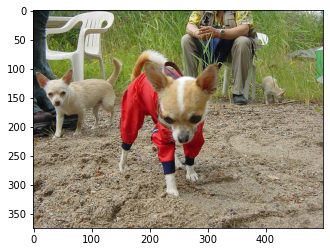

In [11]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Get scoring URI
local_scoring_uri = local_service.scoring_uri

# Make POST request
resp = requests.post(local_scoring_uri, input_data, headers=headers)

print("POST to url", local_scoring_uri)
print("Result:", resp.text)

If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:

In [12]:
local_service.get_logs()

'2021-06-20T11:55:51,660840582+00:00 - gunicorn/run \nFile not found: /var/azureml-app/.\nStarting HTTP server\n2021-06-20T11:55:51,661133587+00:00 - iot-server/run \n2021-06-20T11:55:51,663471527+00:00 - nginx/run \n2021-06-20T11:55:51,669608731+00:00 - rsyslog/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2021-06-20T11:55:51,726605397+00:00 - iot-server/finish 1 0\n2021-06-20T11:55:51,727864918+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (11)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 41\nSPARK_HOME not set. Skipping PySpark Initialization.\nInitializing logger\n2021-06-20 11:55:53,276 | root | INFO | Starting up app insights client\nlogging socket was found. logging is available.\nlogging socket was found. logging is available.\n2021-06-20 11:55:53,276 | root | INFO | Starting up request id generator\n2021-06-20 11:55:53,276 | root | INFO

### Local Webservice Clean Up

In [13]:
# Delete the local webservice
try:
    local_service.delete()
    print("Local service deleted.")
except:
    print("No local service.")

Container has been successfully cleaned up.
Local service deleted.


**Note**: When you do not require your image anymore, you should delete your images as too many images might lead your AML CI to enter an unusable state due to full disk storage.

In order to remove an image run:

`docker image rmi <IMAGE_ID> --force`

In order to prune the docker system (e.g. remove cache) run:

`docker system prune`

# Model Deployment (Compute Target)

### Option 1: Deploy to ACI (Azure Container Instances)

Create new ACI Webservice.

In [14]:
aci_config = AciWebservice.deploy_configuration(cpu_cores=1,
                                                memory_gb=1,
                                                tags=service_tags,
                                                description=service_description)

aci_service = Model.deploy(workspace=ws,
                           name=aci_service_name,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aci_config)

aci_service.wait_for_deployment(True)
print(aci_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.......................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


Retrieve existing ACI Webservice.

In [15]:
aci_service = Webservice(ws, aci_service_name)

#### ACI Webservice Testing

Test the ACI webservice using an HTTP request with the requests library.

POST to url http://073df334-b4cd-43f1-b7cb-67b2459b523e.westeurope.azurecontainer.io/score
Result: {"label": "n02085620-Chihuahua", "probability": "0.9999758"}


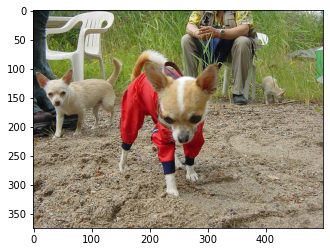

In [16]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Get scoring URI
aci_scoring_uri = aci_service.scoring_uri

# Make POST request
resp = requests.post(aci_scoring_uri, input_data, headers=headers)

print("POST to url", aci_scoring_uri)
print("Result:", resp.text)

If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:

In [17]:
aci_service.get_logs()

'2021-06-20T12:08:13,096050522+00:00 - iot-server/run \n2021-06-20T12:08:13,097214726+00:00 - gunicorn/run \nFile not found: /var/azureml-app/.\nStarting HTTP server\n2021-06-20T12:08:13,098757532+00:00 - rsyslog/run \n2021-06-20T12:08:13,213547535+00:00 - nginx/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2021-06-20T12:08:13,422188468+00:00 - iot-server/finish 1 0\n2021-06-20T12:08:13,427628887+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (11)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 38\nSPARK_HOME not set. Skipping PySpark Initialization.\nInitializing logger\n2021-06-20 12:08:17,055 | root | INFO | Starting up app insights client\nlogging socket was found. logging is available.\nlogging socket was found. logging is available.\n2021-06-20 12:08:17,056 | root | INFO | Starting up request id generator\n2021-06-20 12:08:17,056 | root | INFO

### ACI Webservice Clean Up

In [18]:
# Delete the ACI webservice
try:    
    aci_service.delete()
    print("ACI service deleted.")
except:
    print("No ACI service.")

ACI service deleted.


### Option 2: Deploy to AKS (Azure Kubernetes Service)

Retrieve existing AKS cluster or provision a new one.

In [19]:
# Retrieve all computes from workspace
cts = ws.compute_targets

# Use existing cluster if available, else create a new one
if aks_name in cts and cts[aks_name].type == "AKS":
    print("Found existing AKS cluster, will use it!")
    aks_target = cts[aks_name]
else:
    print("Creating a new AKS cluster...")
    # Use the default provisioning config (no input parameters) or provide parameters to customize
    # For example, to create a dev/test cluster, use:
    prov_config = AksCompute.provisioning_configuration(cluster_purpose = AksCompute.ClusterPurpose.DEV_TEST)
    # Example configuration to use an existing virtual network
    # prov_config.vnet_name = "mynetwork"
    # prov_config.vnet_resourcegroup_name = "myresourcegroup"
    # prov_config.subnet_name = "default"
    # prov_config.service_cidr = "10.0.0.0/16"
    # prov_config.dns_service_ip = "10.0.0.10"
    # prov_config.docker_bridge_cidr = "172.17.0.1/16"
    aks_target = ComputeTarget.create(workspace = ws,
                                      name = aks_name,
                                      provisioning_configuration = prov_config)
    
    print("Waiting for cluster creation completion...")
    aks_target.wait_for_completion(show_output=True)

print("Cluster state:", aks_target.provisioning_state)
print("Cluster is ready!", aks_target)

Creating a new AKS cluster...
Waiting for cluster creation completion...
Creating...................................................................
SucceededProvisioning operation finished, operation "Succeeded"
Cluster state: Succeeded
Cluster is ready! AksCompute(workspace=Workspace.create(name='amlbriksews', subscription_id='bf088f59-f015-4332-bd36-54b988be7c90', resource_group='amlbrikserg'), name=aks-cluster, id=/subscriptions/bf088f59-f015-4332-bd36-54b988be7c90/resourceGroups/amlbrikserg/providers/Microsoft.MachineLearningServices/workspaces/amlbriksews/computes/aks-cluster, type=AKS, provisioning_state=Succeeded, location=westeurope, tags=None)


Create new AKS Webservice.

In [20]:
aks_config = AksWebservice.deploy_configuration(collect_model_data=True,
                                                enable_app_insights=True)

aks_webservices = Webservice.list(workspace = ws, compute_type="AKS")

if any(aks_webservice.name == aks_service_name for aks_webservice in aks_webservices):
    print("Model with same name already deployed")
else:
    if aks_target.provisioning_state == "Succeeded":
        aks_service = Model.deploy(workspace=ws,
                                   name=aks_service_name,
                                   models=[model],
                                   inference_config=inference_config,
                                   deployment_config=aks_config,
                                   deployment_target=aks_target)
        
        aks_service.wait_for_deployment(show_output = True)
        print("Service state:", aks_service.state)
        print("Service details:", aks_service)
    else: 
        raise ValueError("Failed to deploy service to AKS - Error: ", aks_service.error)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.............................................................
Succeeded
AKS service creation operation finished, operation "Succeeded"
Service state: Healthy
Service details: AksWebservice(workspace=Workspace.create(name='amlbriksews', subscription_id='bf088f59-f015-4332-bd36-54b988be7c90', resource_group='amlbrikserg'), name=dog-classification-service-aks, image_id=None, compute_type=None, state=AKS, scoring_uri=Healthy, tags=http://20.101.152.108:80/api/v1/service/dog-classification-service-aks/score, properties={}, created_by={'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-mlops-template-azure-ml.git', 'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-mlops-template-azure-ml.git', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azu

Retrieve existing AKS webservice.

In [21]:
aks_service = Webservice(ws, aks_service_name)

#### AKS Webservice Testing

Test the AKS webservice using an HTTP request with the requests library.

POST to url http://20.101.152.108:80/api/v1/service/dog-classification-service-aks/score
Result: {"label": "n02085620-Chihuahua", "probability": "0.9999758"}


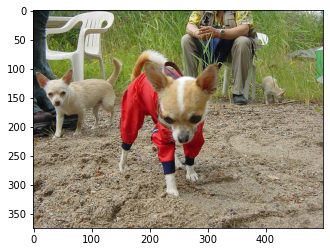

In [22]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get body and header for POST request
# For AKS deployment the service key needs to be in the header as well
# AML generate two keys if key auth is enabled
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
api_key1, api_key2 = aks_service.get_keys()
headers = {"Content-Type": "application/json", "Authorization":("Bearer "+ api_key1)} 

# Get scoring URI
aks_scoring_uri = aks_service.scoring_uri

# Make POST request
resp = requests.post(aks_scoring_uri, input_data, headers=headers)

print("POST to url", aks_scoring_uri)
print("Result:", resp.text)

If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:

In [23]:
aks_service.get_logs()

"2021-06-20T12:23:17,463133373+00:00 - gunicorn/run \nFile not found: /var/azureml-app/.\nStarting HTTP server\n2021-06-20T12:23:17,464951371+00:00 - rsyslog/run \n2021-06-20T12:23:17,466932669+00:00 - iot-server/run \n2021-06-20T12:23:17,467175269+00:00 - nginx/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2021-06-20T12:23:17,544354096+00:00 - iot-server/finish 1 0\n2021-06-20T12:23:17,545871695+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (10)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 40\nSPARK_HOME not set. Skipping PySpark Initialization.\nInitializing logger\n2021-06-20 12:23:19,652 | root | INFO | Starting up app insights client\nlogging socket was found. logging is available.\nlogging socket was found. logging is available.\n2021-06-20 12:23:19,652 | root | INFO | Starting up request id generator\n2021-06-20 12:23:19,653 | root | INFO

### AKS Webservice Clean Up

In [24]:
# Delete the AKS Webservice
try:    
    aks_service.delete()
    print("AKS service deleted.")
except:
    print("No AKS service.")

AKS service deleted.


# Model Deployment (Docker Image)

### Model Packaging

In some cases, you might want to create a Docker image without deploying the model directly to a compute target such as ACI or AKS (if, for example, you plan to deploy to Azure App Service). Or you might want to download the image and run it on a local Docker installation. You might even want to download the files used to build the image, inspect them, modify them, and build the image manually.

Model packaging enables you to do these things. It packages all the assets needed to host a model as a web service and allows you to download either a fully built Docker image or the files needed to build one. There are two ways to use model packaging:

**Option 1: Download a Packaged Model:** Download a Docker image that contains the model and other files needed to host it as a web service.

**Option 2: Generate a Dockerfile:** Download the Dockerfile, model, entry script, and other assets needed to build a Docker image. You can then inspect the files or make changes before you build the image locally.

Creating a package is similar to deploying a model. You use a registered model and an inference configuration. 

For more information on model packaging, check the [Microsoft documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-package-models).

### Option 1: Download a Packaged Model

The following code builds an image, which is registered in the Azure Container Registry of your AML workspace.

If the generate_dockerfile flag is set to False, then an Azure Container Registry (ACR) build task will be triggered and the image will be built on the workspace-native ACR.


In [25]:
# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=False, # Build image on ACR
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

======Starting Image Build on Compute======
The run ID for the image build on compute is imgbldrun_06f3738

azureml-logs/55_azureml-execution-tvmps_4b5773f32f752c18ea85e52f64a2ebf19c1ed2c3cb85dbfe9894e1cc08f073ce_d.txt : 
----
2021-06-20T12:39:04Z Successfully mounted a/an Blobfuse File System at /mnt/batch/tasks/shared/LS_root/jobs/amlbriksews/azureml/imgbldrun_06f3738/mounts/workspaceblobstore
2021-06-20T12:39:04Z The vmsize standard_d11 is not a GPU VM, skipping get GPU count by running nvidia-smi command.
2021-06-20T12:39:04Z Starting output-watcher...
2021-06-20T12:39:05Z IsDedicatedCompute == True, won't poll for Low Pri Preemption
2021-06-20T12:39:06Z Executing 'Copy ACR Details file' on 10.0.0.4
2021-06-20T12:39:06Z Copy ACR Details file succeeded on 10.0.0.4. Output: 
>>>   
>>>   
2021-06-20T12:39:06Z Check if container  already exist exited with 0, 


azureml-logs/55_azureml-execution-tvmps_4b5773f32f752c18ea85e52f64a2ebf19c1ed2c3cb85dbfe9894e1cc08f073ce_d.txt : 
----
Login 


azureml-logs/65_job_prep-tvmps_4b5773f32f752c18ea85e52f64a2ebf19c1ed2c3cb85dbfe9894e1cc08f073ce_d.txt : 
----
bash: /azureml-envs/azureml_5a4df8653abe1a7c5761bbc84bc9ba74/lib/libtinfo.so.5: no version information available (required by bash)
[2021-06-20T12:40:12.431234] Entering job preparation.
[2021-06-20T12:40:14.448494] Starting job preparation.
[2021-06-20T12:40:14.448537] Extracting the control code.
[2021-06-20T12:40:14.473082] fetching and extracting the control code on master node.
[2021-06-20T12:40:14.473130] Starting extract_project.
[2021-06-20T12:40:14.473175] Starting to extract zip file.
[2021-06-20T12:40:15.002219] Finished extracting zip file.
[2021-06-20T12:40:15.173754] Using urllib.request Python 3.0 or later
[2021-06-20T12:40:15.173821] Start fetching snapshots.
[2021-06-20T12:40:15.173870] Start fetching snapshot.
[2021-06-20T12:40:15.173881] Retrieving project from snapshot: ae08137a-4e5b-46ce-86b5-b94235319edb
Starting the daemon thread to refresh tokens in bac


azureml-logs/70_driver_log.txt : 
----
a9323871a3e2: Verifying Checksum
a9323871a3e2: Download complete

logs/azureml/105_azureml.log : 
----
2021-06-20 12:40:48,807|azureml.core.authentication|DEBUG|Time to expire 1814076.192895 seconds

azureml-logs/70_driver_log.txt : 
----
360b353e68fd: Pull complete
ea4e2e1810f8: Pull complete
def12cf7de15: Pull complete
3ae6adfbdb11: Pull complete
2a21fbf2232e: Pull complete
a6d7b4598f46: Pull complete
160f2fe740f8: Pull complete
4c04bbe76c16: Pull complete
08c34cc9301d: Pull complete
edee244ac305: Pull complete
76c6f080c6d7: Pull complete
5768a11b0e87: Pull complete

logs/azureml/105_azureml.log : 
----
2021-06-20 12:41:18,807|azureml.core.authentication|DEBUG|Time to expire 1814046.192693 seconds

logs/azureml/105_azureml.log : 
----
2021-06-20 12:41:48,807|azureml.core.authentication|DEBUG|Time to expire 1814016.192264 seconds

logs/azureml/105_azureml.log : 
----
2021-06-20 12:42:18,808|azureml.core.authentication|DEBUG|Time to expire 181398


azureml-logs/55_azureml-execution-tvmps_4b5773f32f752c18ea85e52f64a2ebf19c1ed2c3cb85dbfe9894e1cc08f073ce_d.txt : 
----
2021-06-20T12:43:48Z job exited with code 0
2021-06-20T12:43:48Z Executing 'JobRelease task' on 10.0.0.4
2021-06-20T12:43:51Z JobRelease task succeeded on 10.0.0.4. Output: 
>>>   2021/06/20 12:43:48 Starting App Insight Logger for task:  jobRelease
>>>   2021/06/20 12:43:48 Version: 3.0.01622.0001 Branch: .SourceBranch Commit: 1141612
>>>   2021/06/20 12:43:48 runSpecialJobTask: os.GetEnv constants.StdouterrDir: /mnt/batch/tasks/shared/LS_root/jobs/amlbriksews/azureml/imgbldrun_06f3738/mounts/workspaceblobstore/azureml/imgbldrun_06f3738/azureml_compute_logs
>>>   2021/06/20 12:43:48 runSpecialJobTask: Raw cmd for postprocessing is passed is: export AZ_BATCHAI_RUN_STATUS='SUCCEEDED';export AZ_BATCHAI_LOG_UPLOAD_FAILED='false';/azureml-envs/azureml_5a4df8653abe1a7c5761bbc84bc9ba74/bin/python $AZ_BATCHAI_JOB_MOUNT_ROOT/workspaceblobstore/azureml/imgbldrun_06f3738/azurem

Package creation Succeeded


In [26]:
# Retrieve ACR details
acr = package.get_container_registry()
print("Address:", acr.address)
print("Username:", acr.username)
print("Password:", acr.password)

Address: 3d5545b15c4c49548d3823156fa90536.azurecr.io
Username: 3d5545b15c4c49548d3823156fa90536
Password: Z+Ji54H8QuUlVZz0xn8rWGEHgr+L9O6e


After a package is created, you can use package.pull() to pull the image to your local Docker environment. This can only be used if `generate_dockerfile` is set to `False`. When the package is pulled, use the `docker images` command to list the local images.

In [27]:
package.pull()

Pulling image from ACR (this may take a few minutes depending on image size)...

3d5545b15c4c49548d3823156fa90536.azurecr.io/inference/dog_clf_model@sha256:e2333f45a0824c78bcc05c34bcc57e38f2fa4217d4e043669ac48e10c1d0fa9c: Pulling from inference/dog_clf_model
2c11b7cecaa5: Already exists
04637fa56252: Already exists
d6e6af23a0f3: Already exists
b4a424de92ad: Already exists
3e5d9ee64909: Already exists
3a846111ff22: Already exists
93a5020c6e19: Already exists
360b353e68fd: Already exists
ea4e2e1810f8: Already exists
def12cf7de15: Already exists
3ae6adfbdb11: Already exists
2a21fbf2232e: Already exists
a6d7b4598f46: Already exists
160f2fe740f8: Already exists
4c04bbe76c16: Already exists
08c34cc9301d: Already exists
edee244ac305: Already exists
76c6f080c6d7: Already exists
5768a11b0e87: Already exists
a9323871a3e2: Already exists
f0100cc25354: Already exists
00306748b6d5: Already exists
ae931a1816e0: Already exists
61fdaacf418d: Already exists
Digest: sha256:e2333f45a0824c78bcc05c34bcc57e

### Option 2: Generate a Dockerfile

In [28]:
# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=True, # Do not build image but create a Dockerfile and deployment assets instead
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

Package creation Succeeded


After you create a Dockerfile, you can use package.save() to download the Dockerfile and corresponding artifacts to your local machine. This can only be used if `generate_dockerfile` is set to `True`.

In [29]:
package.save("../environments/docker/inferencing_image")

Logging into Docker registry 3d5545b15c4c49548d3823156fa90536.azurecr.io


In order to build the image, to push it to the ACR of the AML workspace and to run it inside a container, run the following commands from the project root directory:

Login to the Azure CLI using your device code:

`az login`

Login to the ACR:

`az acr login -n <ACR_NAME>`

Build the image:

`cd environments/docker/inferencing_image`

`docker build -t inference/dog_clf_model:1.0 .`

Tag the image:

`docker tag inference/dog_clf_model:1.0 <ACR_NAME>.azurecr.io/inference/dog_clf_model:1.0`

Push the image:

`docker push <ACR_NAME>.azurecr.io/inference/dog_clf_model:1.0`

Alternatively to the previous three steps, build the image on the ACR:

`az acr build --image inference/dog_clf_model:1.0 --registry <ACR_NAME> .`

### Model Packaging Local Deployment

To run the image on your local compute target (e.g. AML CI), run the following:

`docker run -p 6789:5001 --name dog-clf-container -it inference/dog_clf_model:1.0`

This command starts a container with the 1.0 version of the image named `inference/dog_clf_model` (in interactive mode). It maps local port 6789 to the port in the container on which the web service is listening (5001). It also assigns the name dog-clf-container to the container, which makes the container easier to stop. After the container is started, you can submit requests to http://localhost:6789/score.

To see the running container run:

`docker ps`


### Model Packaging Local Webservice Testing

POST to url http://localhost:6789/score
Result: {"label": "n02085620-Chihuahua", "probability": "0.9999758"}


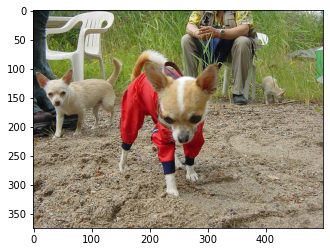

In [30]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Make POST request
resp = requests.post("http://localhost:6789/score", input_data, headers=headers)

print("POST to url", local_scoring_uri)
print("Result:", resp.text)

### Model Packaging Clean Up

To stop the running container run:

`docker stop dog-clf-container`

Do not forget to clean up the image:

`docker images`

`docker image rmi <IMAGE_ID> --force`

Test the local webservice using an HTTP request with the requests library.

### Deploy Docker Image to AKS

We will use kubectl (the Kubernetes CLI) to deploy the image to AKS.

Create a shell script to create an AKS Cluster (with attached ACR) and configure kubectl to connect to this Kubernetes cluster:

In [32]:
%%writefile ../infrastructure/aks/aks_cluster.sh
# Define parameters
resourceGroupName=aksrg$RANDOM
aksClusterName=aks$RANDOM
acrName=3d5545b15c4c49548d3823156fa90536
region=westeurope

# Create a resource group
az group create \
  --name $resourceGroupName\
  --location $region

# Option 1: Create an AKS cluster
az aks create \
    --resource-group $resourceGroupName \
    --name $aksClusterName \
    --node-count 2 \
    --generate-ssh-keys \
    --attach-acr $acrName

# Option 2: Or use existing one instead
az aks update \
    --resource-group $resourceGroupName \
    --name $aksClusterName \
    --attach-acr $acrName

# Install kubectl
sudo az aks install-cli

# Configure kubectl to connect to the AKS cluster
az aks get-credentials \
    --resource-group $resourceGroupName \
    --name $aksClusterName

Overwriting ../infrastructure/aks/aks_cluster.sh


In order to set up the AKS cluster for deployment run the following from the project root directory:

`cd infrastructure/aks`

`bash aks_cluster.sh`

Create a Kubernetes manifest to deploy the stanford dogs inferencing image to AKS.

In [33]:
%%writefile ../infrastructure/aks/aks_dog_clf_deployment.yml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: dog-clf-deployment
spec:
  replicas: 1
  selector:
    matchLabels:
      app: dog-clf-app
  template:
    metadata:
      labels:
        app: dog-clf-app
    spec: 
      containers:
      - image: 3d5545b15c4c49548d3823156fa90536.azurecr.io/inference/dog_clf_model:1.0
        name: dog-clf-container
---
apiVersion: v1
kind: Service
metadata:
  labels:
    app: dog-clf-service
  name: dog-clf-service
spec:
  ports:
  - targetPort: 5001
    port: 80
    protocol: TCP
  selector:
    app: dog-clf-app
  type: LoadBalancer

Overwriting ../infrastructure/aks/aks_dog_clf_deployment.yml


In order to deploy the inferencing image to AKS, run the following from the <PROJECT_ROOT>/infrastructure/aks directory:

`kubectl apply -f aks_dog_clf_deployment.yml`

Check whether container was successfully deployed:

`kubectl get pods`

Check webservice status and retrieve external IP:

`kubectl get service dog-clf-service --watch`

### Test the Deployed Webservice

Insert external IP from above command.

{"label": "n02085620-Chihuahua", "probability": "0.9999758"}


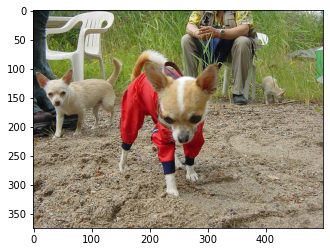

In [35]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(data_example_path))

# Preprocess the image
input_data = preprocess_image(data_example_path)

# Get header and body for POST request
input_data = "{\"data\": " + str(input_data.tolist()) + "}"
headers = {"Content-Type": "application/json"}

# Make the request and display the response.
# Add the external IP from above watch command in below web request
resp = requests.post("http://20.93.241.129/score", input_data, headers=headers)
print(resp.text)

# Resource Clean Up

Delete the AKS cluster.

In [36]:
aks_target.delete()

**Note**: Don't forget to manually delete the resource group with the AKS cluster that has been created through the `aks_cluster.sh` shell script.